In [1]:
import logging
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyro
from collections import defaultdict

In [2]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.clear_param_store()
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

In [3]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.util import ignore_jit_warnings
from pyro import poutine
from pyro.ops.indexing import Vindex
from pyro.infer.autoguide import AutoDelta
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO, TraceTMC_ELBO, infer_discrete, config_enumerate

### Load in simulated data

This data is fully diploid with GC bias and no gamma distributed noise. True values for each param can be found in `gc_slope`, `gc_int`, `true_frac_rt`, `true_s_time`, `A`, `sigma1` (negative bc gamma noise is absent), `total_mapped_reads_hmmcopy`, `true_G1_state`, `true_rt_state`

In [4]:
cn_s = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/fig2/D11/s_phase_cells.tsv', sep='\t')
cn_s.head()

chr    start      end        gc     mcf7rt  bin_size clone_id  \
0   1  1000000  1500000  0.598330  81.441980    500000        A   
1   1  1500000  2000000  0.539496  79.131013    500000        A   
2   1  2000000  2500000  0.594508  78.557313    500000        A   
3   1  3000000  3500000  0.584570  70.388076    500000        A   
4   1  4000000  4500000  0.482572  48.663092    500000        A   

   clone_cn_state   cell_id  true_G1_state  ...  true_rt_state  \
0             2.0  cell_S_0            2.0  ...              1   
1             2.0  cell_S_0            2.0  ...              1   
2             2.0  cell_S_0            2.0  ...              1   
3             2.0  cell_S_0            2.0  ...              1   
4             2.0  cell_S_0            2.0  ...              0   

   true_observed_CN  true_frac_rt  total_mapped_reads_hmmcopy  gc_slope  \
0          4.460986       0.49679                     1000000       1.2   
1          4.273379       0.49679                     1000000       1.2   
2          4.448664       0.49679                     1000000       1.2   
3          4.416712       0.49679                     1000000       1.2   
4          2.048070       0.49679                     1000000       1.2   

   gc_int  sigma1    A    B    rpm  
0     0.0    -1.0  0.1  0.0  287.0  
1     0.0    -1.0  0.1  0.0  277.0  
2     0.0    -1.0  0.1  0.0  284.0  
3     0.0    -1.0  0.1  0.0  265.0  
4     0.0    -1.0  0.1  0.0  128.0  

[5 rows x 22 columns]

In [5]:
cn_g1 = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/fig2/D11/g1_phase_cells.tsv', sep='\t')
cn_g1.head()

chr    start      end        gc     mcf7rt  bin_size clone_id  \
0   1  1000000  1500000  0.598330  81.441980    500000        A   
1   1  1500000  2000000  0.539496  79.131013    500000        A   
2   1  2000000  2500000  0.594508  78.557313    500000        A   
3   1  3000000  3500000  0.584570  70.388076    500000        A   
4   1  4000000  4500000  0.482572  48.663092    500000        A   

   clone_cn_state   cell_id  true_G1_state  ...  true_rt_state  \
0             2.0  cell_G_0            2.0  ...              0   
1             2.0  cell_G_0            2.0  ...              0   
2             2.0  cell_G_0            2.0  ...              0   
3             2.0  cell_G_0            2.0  ...              0   
4             2.0  cell_G_0            2.0  ...              0   

   true_observed_CN  true_frac_rt  total_mapped_reads_hmmcopy  gc_slope  \
0          2.230493           0.0                     1000000       1.2   
1          2.136689           0.0                     1000000       1.2   
2          2.224332           0.0                     1000000       1.2   
3          2.208356           0.0                     1000000       1.2   
4          2.048070           0.0                     1000000       1.2   

   gc_int  sigma1    A    B    rpm  
0     0.0    -1.0  0.1  0.0  199.0  
1     0.0    -1.0  0.1  0.0  194.0  
2     0.0    -1.0  0.1  0.0  222.0  
3     0.0    -1.0  0.1  0.0  231.0  
4     0.0    -1.0  0.1  0.0  201.0  

[5 rows x 22 columns]

In [6]:
cn_s_reads = cn_s.pivot(columns='cell_id', index=['chr', 'start'], values='reads')
cn_s_reads = torch.tensor(cn_s_reads.values).to(torch.float32)

cn_g1_reads = cn_g1.pivot(columns='cell_id', index=['chr', 'start'], values='reads')
cn_g1_reads = torch.tensor(cn_g1_reads.values).to(torch.float32)
cn_g1_reads.shape

torch.Size([5451, 400])

In [7]:
cn_s_cn = cn_s.pivot(columns='cell_id', index=['chr', 'start'], values='true_G1_state')
cn_s_cn = torch.tensor(cn_s_cn.values).to(torch.float32)

cn_g1_cn = cn_g1.pivot(columns='cell_id', index=['chr', 'start'], values='true_G1_state')
cn_g1_cn = torch.tensor(cn_g1_cn.values).to(torch.float32)
cn_g1_cn.shape

torch.Size([5451, 400])

In [8]:
gc_profile = cn_s[['chr', 'start', 'gc']].drop_duplicates()
rt_prior_profile = cn_s[['chr', 'start', 'mcf7rt']].drop_duplicates()

gc_profile = gc_profile.dropna()
rt_prior_profile = rt_prior_profile.dropna()

gc_profile = torch.tensor(gc_profile['gc'].values).unsqueeze(-1).to(torch.float32)
rt_prior_profile = torch.tensor(rt_prior_profile['mcf7rt'].values).unsqueeze(-1).to(torch.float32)
rt_prior_profile = rt_prior_profile / 100.  # scale from 0-1 with early replicating regions being close to 1
gc_profile.shape

torch.Size([5451, 1])

In [9]:
rt_prior_profile.min(), rt_prior_profile.max()

(tensor(0.1056), tensor(0.8236))

Set initial guesses for relevant parameters

In [10]:
gc0 = 0.5
gc1 = 0.5
A = 1

### Plot the true read count heatmap for G1-phase cells

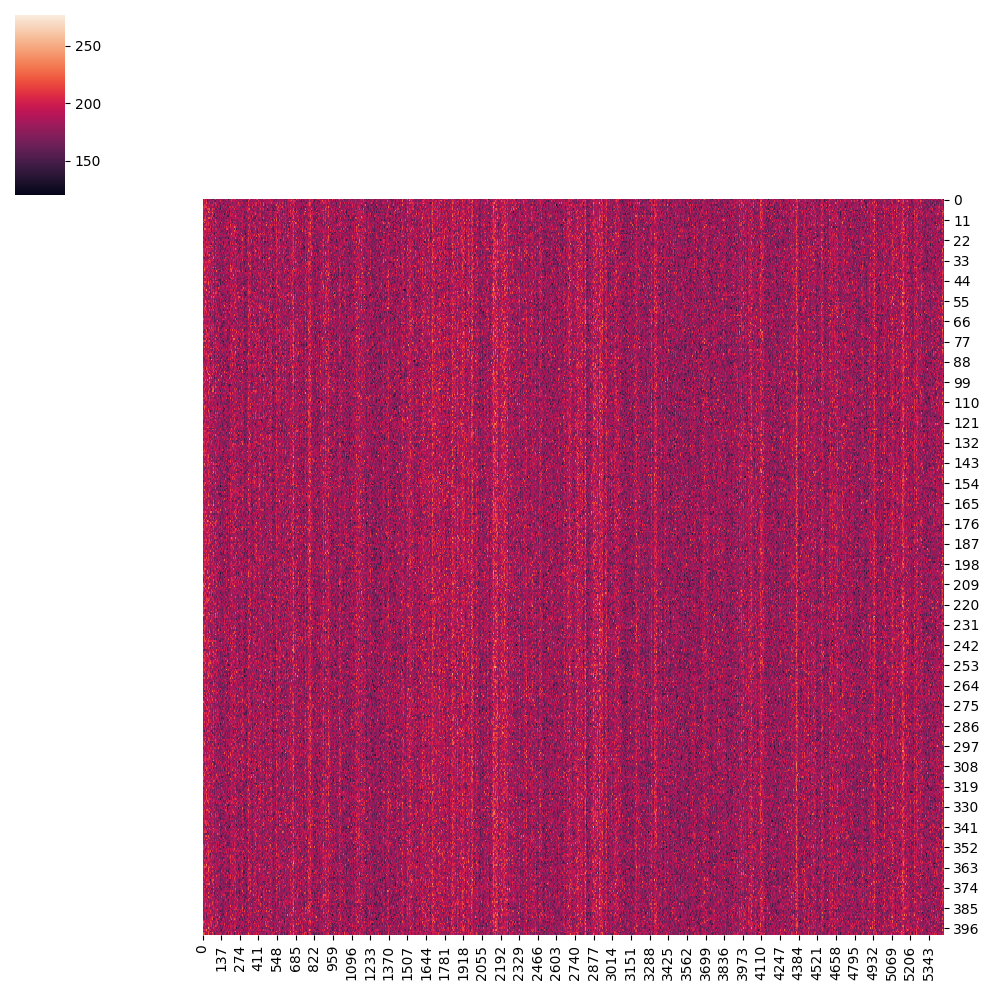

In [11]:
sns.clustermap(cn_g1_reads.numpy().astype(float).T, col_cluster=False, row_cluster=False)
plt.show()

### Run model for G1-phase cells

In [12]:
u_guess = torch.mean(cn_g1_reads) / torch.mean(cn_g1_cn)
u_guess

tensor(91.7263)

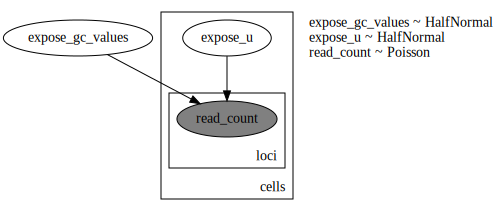

In [13]:
pyro.clear_param_store()

@config_enumerate
def model_G1(cn_profiles, gc_profile, gc0, gc1, read_profiles=None, u_guess=91):
    with ignore_jit_warnings():
        num_loci, num_cells = map(int, cn_profiles.shape)
        if read_profiles is not None:
            assert read_profiles.shape == cn_profiles.shape
        assert num_loci == gc_profile.shape[0]

    # scale each cell's read count so that it sums to 1 million reads and do some reshaping
    epsilon = torch.finfo(torch.float32).eps
    
    # draw GC bias parameters from halfnormal distributions, using gc0 and gc1 as initial guesses
    gc_values = pyro.sample("expose_gc_values", 
                            dist.HalfNormal(torch.tensor([gc0+epsilon, gc1+epsilon]), 0.1).to_event(1))
    
    # add gc bias to the total CN
    m = torch.nn.Softplus()
    gc_factor = (gc_profile * gc_values[1]) + gc_values[0]
    biased_CN = cn_profiles * m(gc_factor)

    # draw true read count from Poisson distribution
    with pyro.plate("cells", num_cells):
        # per cell reads per copy scaling factor for each bin
        u = pyro.sample("expose_u", dist.HalfNormal(torch.ones(num_cells)*u_guess, 10.0))
        expected_reads = biased_CN * u.reshape(1, -1)
        with pyro.plate("loci", num_loci):
            read_count = pyro.sample("read_count", 
                                     dist.Poisson(expected_reads, validate_args=False),
                                     obs=read_profiles)
    
    return read_count

pyro.render_model(model_G1, model_args=(cn_g1_cn, gc_profile, gc0, gc1, cn_g1_reads), 
                  render_distributions=True, render_params=True)

In [14]:
optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)

In [15]:
guide_G1 = AutoDelta(poutine.block(model_G1, expose_fn=lambda msg: msg["name"].startswith("expose_")))
svi = SVI(model_G1, guide_G1, optim, loss=elbo)

In [16]:
logging.info('Start Inference.')
losses = []
for i in range(1000):
    loss = svi.step(cn_g1_cn, gc_profile, gc0, gc1, cn_g1_reads, u_guess)

    if i >= 300:
        loss_diff = abs((losses[-1] - loss) / losses[-1])
        if loss_diff < 5e-5:
            logging.info('ELBO converged at iteration ' + str(i))
            break

    losses.append(loss)
    print('.' if i % 200 else '\n', end='')

map_estimates = guide_G1(cn_g1_cn, gc_profile, gc0, gc1, cn_g1_reads, u_guess)

Start Inference.
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/traceenum_elbo.py:356: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  "TraceEnum_ELBO found no sample sites configured for enumeration. "



.......................................................................................................................................................................................................
.................................................................................................

ELBO converged at iteration 300


..

See how close the inferred GC params are to their true values

In [17]:
gc0_fit, gc1_fit = map_estimates['expose_gc_values'].detach().numpy()
u_fit = map_estimates['expose_u'].detach().numpy()
gc_values = [gc0_fit, gc1_fit]

print(gc0_fit, gc1_fit)

0.55946124 0.58801


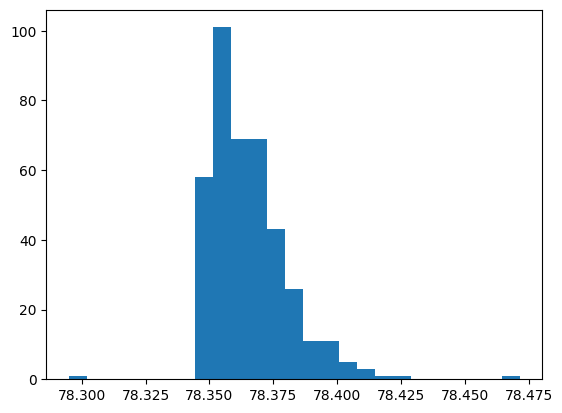

In [18]:
plt.hist(u_fit, bins=25)
plt.show()

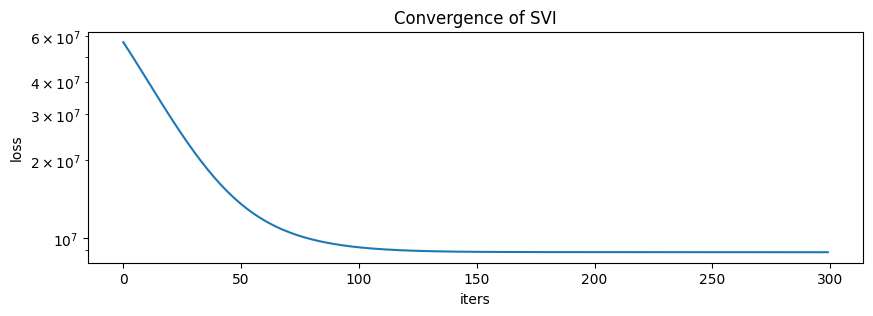

In [19]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI')
plt.show()

### Generate read depth data using the fitted model and plot the resulting heatmap

In [20]:
pyro.clear_param_store()

conditioned_model_G1 = poutine.condition(
    model_G1,
    data={
        'expose_gc_values': torch.tensor(gc_values),
        'expose_u': torch.tensor(u_fit)
    }
)

model_G1_trace = pyro.poutine.trace(conditioned_model_G1)
samples_G1 = model_G1_trace.get_trace(cn_g1_cn, gc_profile, gc0_fit, gc1_fit)
sim_g1_reads = samples_G1.nodes['read_count']['value']


sim_g1_reads.shape

torch.Size([5451, 400])

In [21]:
sim_g1_reads

tensor([[199., 194., 176.,  ..., 191., 187., 204.],
        [189., 210., 172.,  ..., 187., 178., 193.],
        [191., 187., 201.,  ..., 199., 224., 186.],
        ...,
        [199., 182., 202.,  ..., 178., 187., 173.],
        [179., 201., 197.,  ..., 184., 171., 180.],
        [149., 170., 185.,  ..., 181., 177., 203.]])

In [22]:
cn_g1_reads

tensor([[199., 207., 219.,  ..., 202., 208., 200.],
        [194., 204., 178.,  ..., 193., 188., 203.],
        [222., 171., 210.,  ..., 216., 213., 222.],
        ...,
        [205., 178., 223.,  ..., 206., 190., 226.],
        [210., 186., 193.,  ..., 181., 186., 196.],
        [140., 181., 173.,  ..., 192., 187., 195.]])

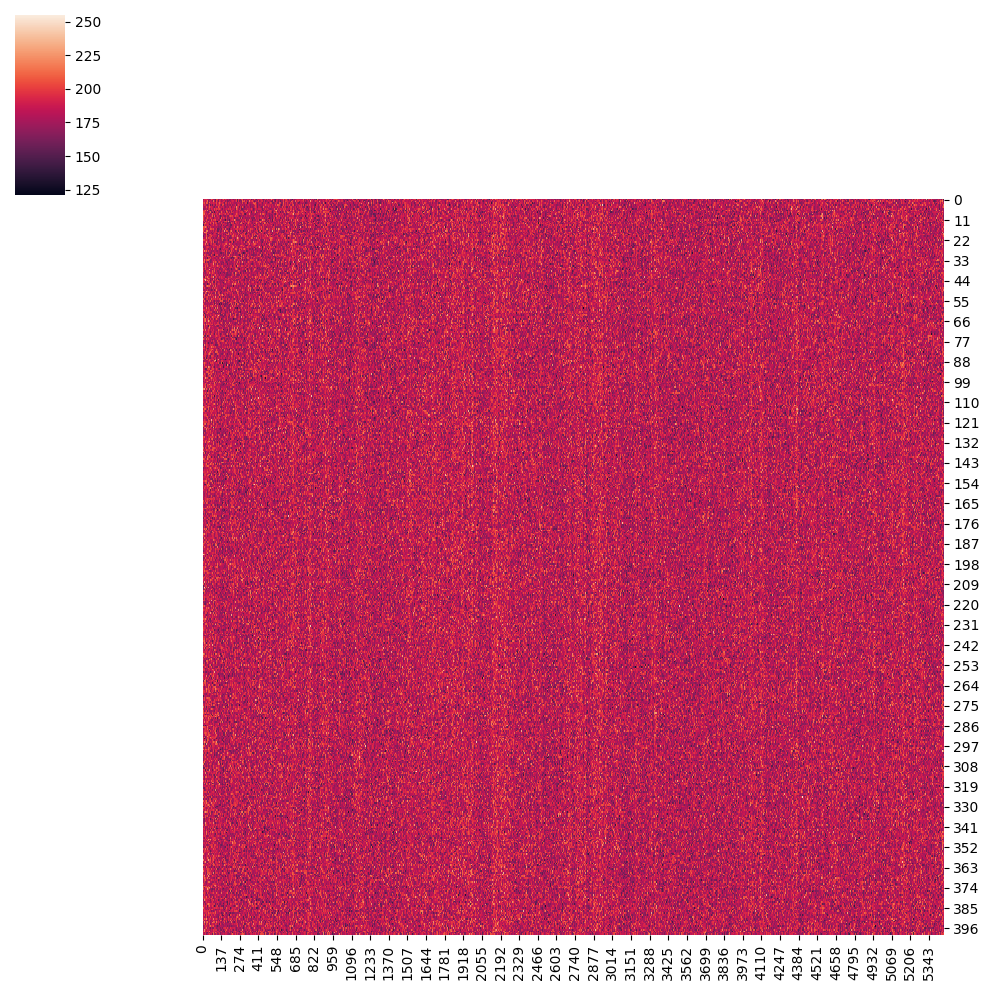

In [23]:
sns.clustermap(sim_g1_reads.numpy().astype(float).T, col_cluster=False, row_cluster=False)
plt.show()

In [24]:
cn_g1_mat_df = cn_g1.pivot(index='cell_id', columns=['chr', 'start'], values='reads')
sim_g1_reads_df = pd.DataFrame(sim_g1_reads.numpy().astype(float), columns=cn_g1_mat_df.index, index=cn_g1_mat_df.columns)
sim_g1_reads_df = sim_g1_reads_df.melt(ignore_index=False, value_name='reads').reset_index()
sim_g1_reads_df.head()

chr    start   cell_id  reads
0   1  1000000  cell_G_0  199.0
1   1  1500000  cell_G_0  189.0
2   1  2000000  cell_G_0  191.0
3   1  3000000  cell_G_0  209.0
4   1  4000000  cell_G_0  154.0

In [25]:
sim_g1_reads_df = pd.merge(sim_g1_reads_df, cn_g1[['chr', 'start', 'gc']].drop_duplicates())
sim_g1_reads_df.head()

chr    start     cell_id  reads       gc
0   1  1000000    cell_G_0  199.0  0.59833
1   1  1000000    cell_G_1  194.0  0.59833
2   1  1000000   cell_G_10  176.0  0.59833
3   1  1000000  cell_G_100  174.0  0.59833
4   1  1000000  cell_G_101  191.0  0.59833

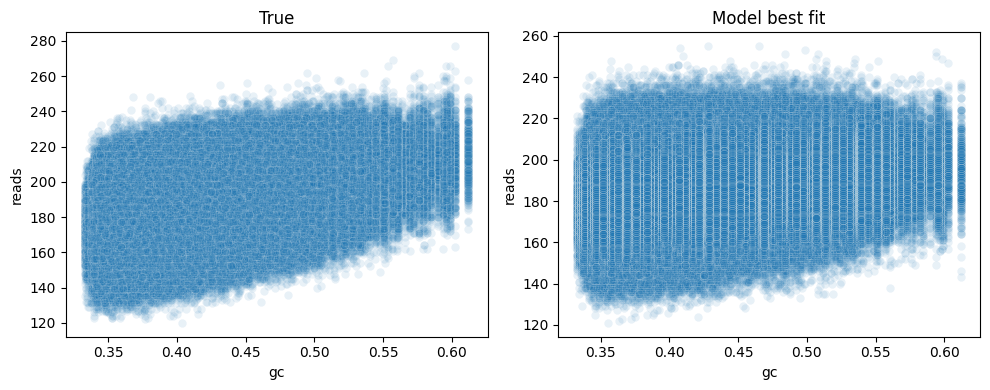

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
ax = ax.flatten()

sns.scatterplot(data=cn_g1, x='gc', y='reads', alpha=0.1, ax=ax[0])
sns.scatterplot(data=sim_g1_reads_df, x='gc', y='reads', alpha=0.1, ax=ax[1])
ax[0].set_title('True')
ax[1].set_title('Model best fit')
plt.show()

### Run model for S-phase cells

In [27]:
# initial guess for u is that half the bins are replicated in each cell
u_guess = torch.mean(cn_s_reads) / (1.5 * torch.mean(cn_s_cn))
u_guess

tensor(61.1509)

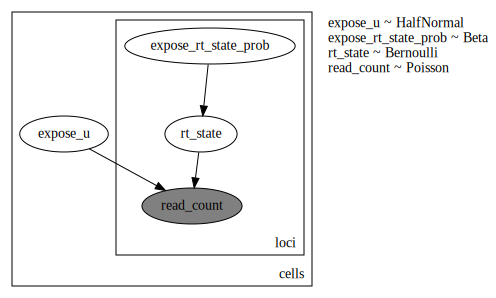

In [28]:
pyro.clear_param_store()

@config_enumerate
def model_S(cn_profiles, gc_profile, gc_values, read_profiles=None, u_guess=61.0):
    with ignore_jit_warnings():
        num_loci, num_cells = map(int, cn_profiles.shape)
        if read_profiles is not None:
            assert read_profiles.shape == cn_profiles.shape
        assert num_loci == gc_profile.shape[0]

    # scale each cell's read count so that it sums to 1 million reads and do some reshaping
    epsilon = torch.finfo(torch.float32).eps
    
    # reads_per_cell = int(1e6)
    # read_profiles = read_profiles * reads_per_cell / torch.sum(read_profiles, 0).reshape(1, -1)
    
    alphas = torch.ones(num_loci, num_cells)
    betas = torch.ones(num_loci, num_cells)
    
    # add gc bias to the total CN
    m = torch.nn.Softplus()
    gc_factor = (gc_profile * gc_values[1]) + gc_values[0]
    biased_CN = cn_profiles * m(gc_factor)

    # draw true read count from Poisson distribution
    with pyro.plate("cells", num_cells):
        # per cell reads per copy scaling factor for each bin
        u = pyro.sample("expose_u", dist.HalfNormal(torch.ones(num_cells)*u_guess, 10.0))
        expected_reads = biased_CN * u.reshape(1, -1)
        with pyro.plate("loci", num_loci):
            # draw each bin's replication probability from Beta
            prob_replicated = pyro.sample("expose_rt_state_prob", dist.Beta(alphas, betas))
            # draw replicated status from Bernoulli
            replicated = pyro.sample("rt_state", dist.Bernoulli(prob_replicated))
            # double the expected read count in bins that have been replicated
            rep_reads = expected_reads * (1 + replicated)

            read_count = pyro.sample("read_count", 
                                     dist.Poisson(rep_reads),
                                     obs=read_profiles)
    
    return read_count

pyro.render_model(model_S, model_args=(cn_s_cn, gc_profile, gc_values, cn_s_reads, u_guess), 
                  render_distributions=True, render_params=True)

In [29]:
optim_S = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo_S = TraceEnum_ELBO(max_plate_nesting=2)

# def initialize(seed, model_S, optim_S, elbo_S, cn_s_reads, cn_s_cn, gc_profile, gc_values):
#     global guide_S, svi_S
#     pyro.set_rng_seed(seed)
#     pyro.clear_param_store()
#     guide_S = AutoDelta(poutine.block(model_S, expose_fn=lambda msg: msg["name"].startswith("expose_")))
#     svi_S = SVI(model_S, guide_S, optim_S, loss=elbo_S)
#     return svi_S.loss(model_S, guide_S, cn_s_reads, cn_s_cn, gc_profile, gc_values)

# # Choose the best among 100 random initializations.
# loss, seed = min((initialize(
#     seed, model_S, optim_S, elbo_S, cn_s_reads, cn_s_cn, gc_profile, gc_values
# ), seed) for seed in range(1))
# # initialize(
# #     seed, model_S, optim_S, elbo_S, cn_s_reads, cn_s_cn, gc_profile, gc_values
# # )
# print('seed = {}, initial_loss = {}'.format(seed, loss))

In [30]:
guide_S = AutoDelta(poutine.block(model_S, expose_fn=lambda msg: msg["name"].startswith("expose_")))
svi_S = SVI(model_S, guide_S, optim_S, loss=elbo_S)

In [31]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

logging.info('Start Inference.')
losses = []
for i in range(1000):
    loss = svi_S.step(cn_s_cn, gc_profile, gc_values, cn_s_reads, u_guess)

    # try a fancier convergence check.. not sure if it's working though
    if i >= 10:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            logging.info('ELBO converged at iteration ' + str(i))
            break

    losses.append(loss)
    print('.', end='')

map_estimates_S = guide_S(cn_s_cn, gc_profile, gc_values, cn_s_reads, u_guess)

Start Inference.


................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

ELBO converged at iteration 976


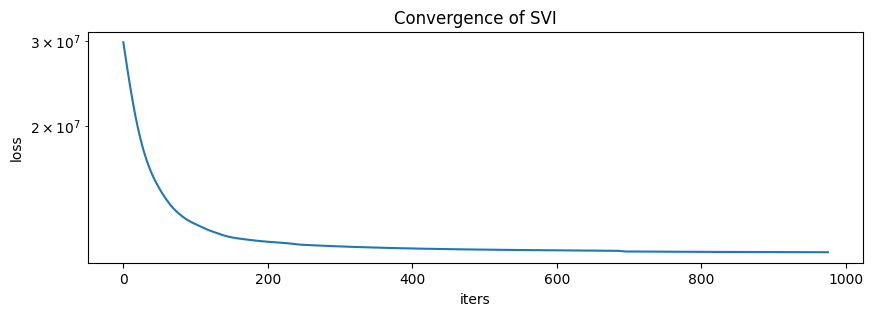

In [32]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI')
plt.show()

No handles with labels found to put in legend.


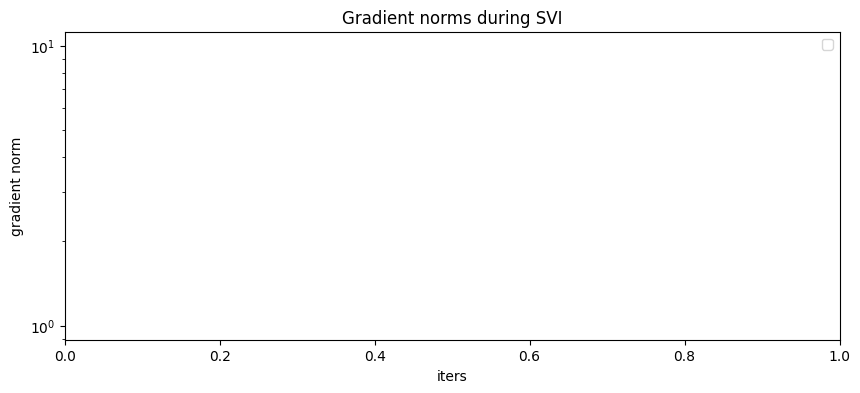

In [33]:
plt.figure(figsize=(10,4), dpi=100).set_facecolor('white')
for name, grad_norms in gradient_norms.items():
    plt.plot(grad_norms, label=name)
plt.xlabel('iters')
plt.ylabel('gradient norm')
plt.yscale('log')
plt.legend(loc='best')
plt.title('Gradient norms during SVI')
plt.show()

### Do a bunch of checks to make sure model results seem reasonable

In [34]:
pyro.get_param_store().keys()

dict_keys(['AutoDelta.expose_u', 'AutoDelta.expose_rt_state_prob'])

In [35]:
map_estimates_S.keys()

dict_keys(['expose_u', 'expose_rt_state_prob'])

In [37]:
rt_state_probs = map_estimates_S['expose_rt_state_prob'].detach().numpy()

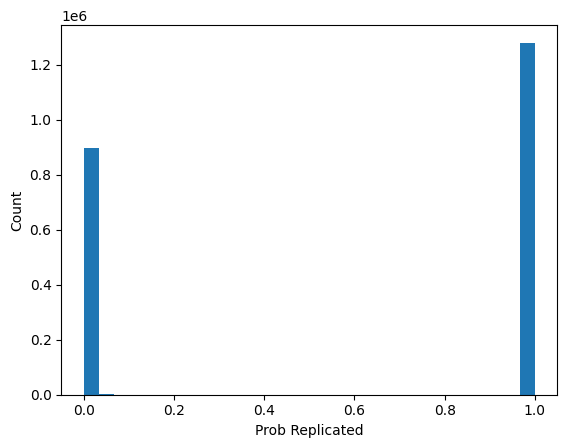

In [38]:
plt.hist(rt_state_probs.reshape(-1, 1), bins=30)
plt.xlabel('Prob Replicated')
plt.ylabel('Count')
plt.show()

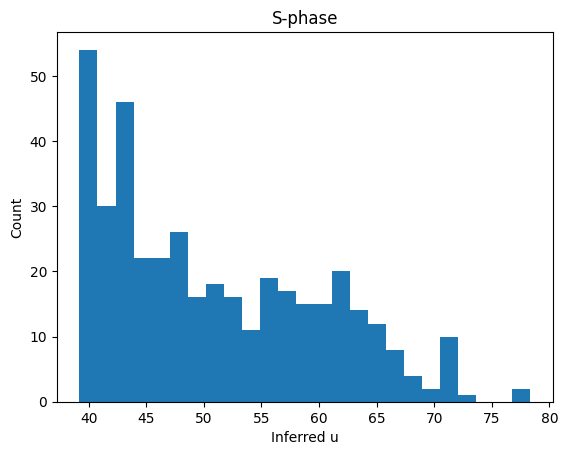

In [39]:
u_fit_s = map_estimates_S['expose_u'].detach().numpy()
plt.hist(u_fit_s, bins=25)
plt.xlabel('Inferred u')
plt.ylabel('Count')
plt.title('S-phase')
plt.show()

### Plot the true reads heatmap for S-phase cells

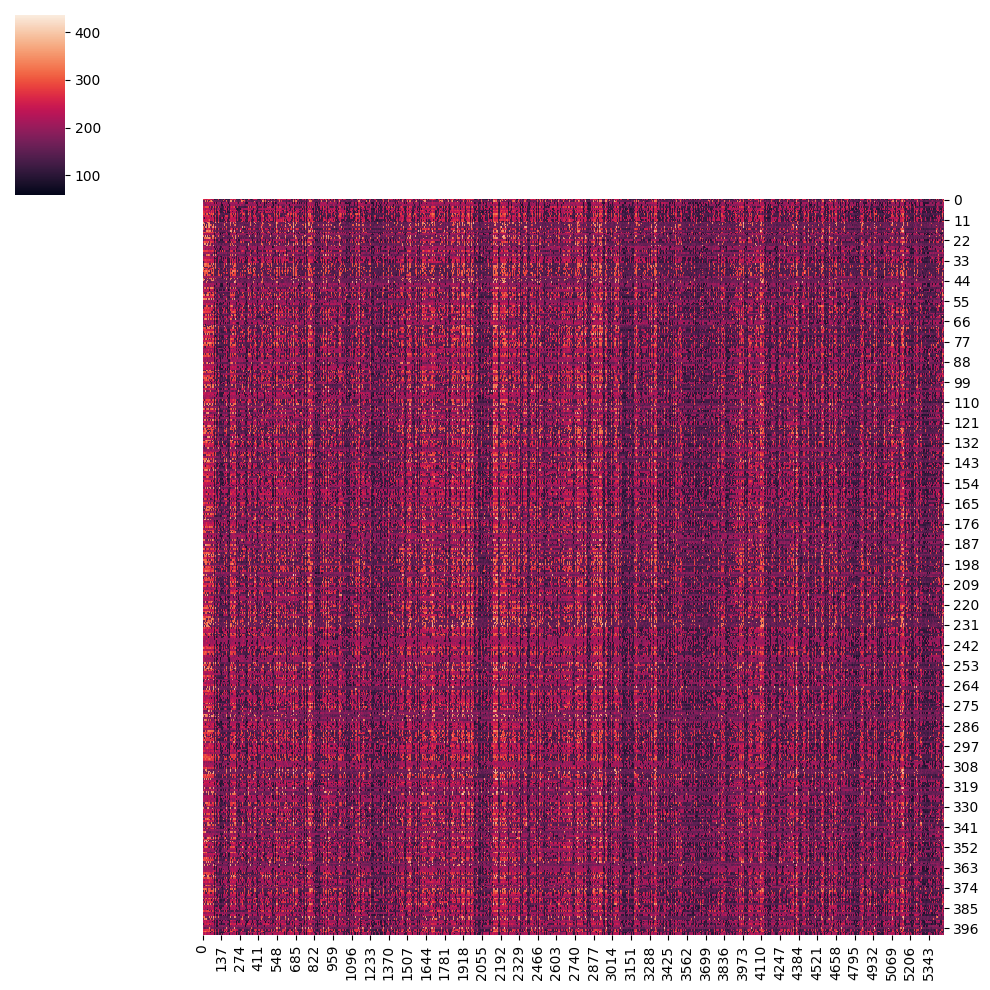

In [40]:
sns.clustermap(cn_s_reads.numpy().astype(float).T, col_cluster=False, row_cluster=False)
plt.show()

### Simulate S-phase cells from the fitted (conditioned) model and plot the heatmap

In [41]:
pyro.clear_param_store()

conditioned_model_S = poutine.condition(
    model_S,
    data={
        'expose_rt_state_prob': torch.tensor(rt_state_probs),
        'expose_u': torch.tensor(u_fit_s)
    }
)

model_S_trace = pyro.poutine.trace(conditioned_model_S)
samples_S = model_S_trace.get_trace(cn_s_cn, gc_profile, gc_values)
sim_s_reads = samples_S.nodes['read_count']['value']

sim_s_reads = model_S(cn_s_cn, gc_profile, gc_values)
sim_s_reads.shape

torch.Size([5451, 400])

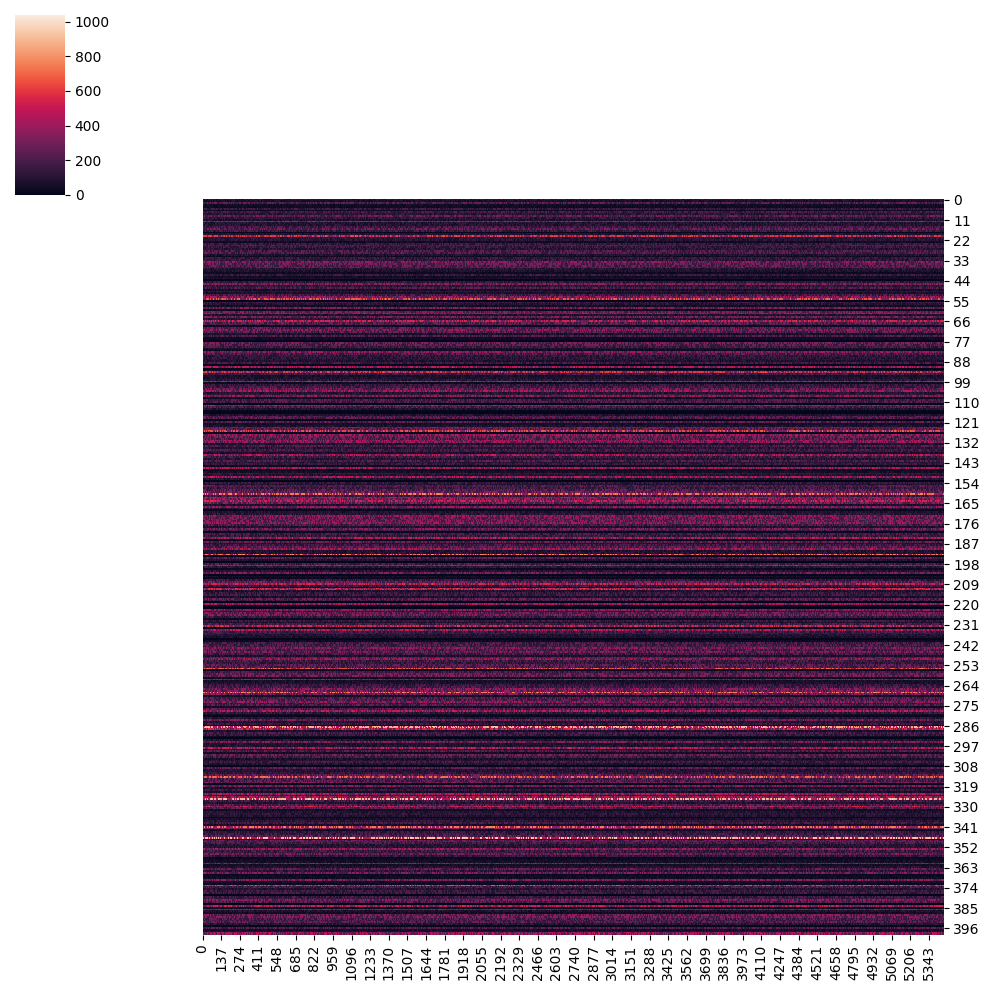

In [42]:
sns.clustermap(sim_s_reads.numpy().astype(float).T[np.argsort(u_fit_s), :], col_cluster=False, row_cluster=False)
plt.show()

Double check that the matrices aren't exact duplicates of one another

In [43]:
sim_s_reads

tensor([[281.,  68., 543.,  ..., 273.,  51., 432.],
        [132.,  82., 531.,  ..., 265.,  54., 402.],
        [250.,  84., 559.,  ..., 113., 100., 421.],
        ...,
        [246.,  81., 248.,  ..., 124.,  46., 238.],
        [249.,  70., 488.,  ..., 246., 104., 199.],
        [109., 137., 265.,  ..., 255.,  45., 216.]])

In [44]:
cn_s_reads

tensor([[287., 173., 216.,  ..., 327., 325., 253.],
        [277., 333., 241.,  ..., 259., 292., 240.],
        [284., 375., 210.,  ..., 292., 149., 229.],
        ...,
        [241., 346., 237.,  ..., 274., 170., 216.],
        [116., 287.,  88.,  ..., 238., 144., 191.],
        [214., 310., 200.,  ..., 124., 121., 195.]])

### See if replicated bins (according to model) have higher probabilities

In [45]:
rt_state_probs.shape

(5451, 400)

In [46]:
# make a df matrix for every current output object
cn_s_reads_df = cn_s.pivot(index='cell_id', columns=['chr', 'start'], values='reads')

rt_state_probs_df = pd.DataFrame(rt_state_probs, columns=cn_s_reads_df.index, index=cn_s_reads_df.columns)

rt_state_probs_df.head()

cell_id      cell_S_0  cell_S_1  cell_S_10  cell_S_100  cell_S_101  \
chr start                                                            
1   1000000  0.995722  0.993999   0.997086    0.994092    0.993386   
    1500000  0.993115  0.993547   0.995234    0.994399    0.995767   
    2000000  0.993185  0.985918   0.995921    0.991098    0.993650   
    3000000  0.992603  0.991733   0.995139    0.996069    0.002526   
    4000000  0.003946  0.995884   0.996014    0.003940    0.995164   

cell_id      cell_S_102  cell_S_103  cell_S_104  cell_S_105  cell_S_106  ...  \
chr start                                                                ...   
1   1000000    0.997930    0.995828    0.995944    0.997274    0.992336  ...   
    1500000    0.990600    0.994028    0.994437    0.989888    0.005614  ...   
    2000000    0.993646    0.995839    0.990174    0.002679    0.994203  ...   
    3000000    0.993521    0.995905    0.994546    0.996812    0.996732  ...   
    4000000    0.997067    0.005815    0.996710    0.004554    0.995162  ...   

cell_id      cell_S_90  cell_S_91  cell_S_92  cell_S_93  cell_S_94  cell_S_95  \
chr start                                                                       
1   1000000   0.987151   0.994074   0.995892   0.994578   0.997331   0.991027   
    1500000   0.996150   0.996489   0.994429   0.993280   0.996201   0.993962   
    2000000   0.994869   0.994359   0.993512   0.995819   0.995795   0.997394   
    3000000   0.995771   0.994656   0.996190   0.996394   0.994706   0.990861   
    4000000   0.995786   0.994905   0.010333   0.997152   0.988693   0.994147   

cell_id      cell_S_96  cell_S_97  cell_S_98  cell_S_99  
chr start                                                
1   1000000   0.994630   0.990417   0.993928   0.997085  
    1500000   0.992125   0.997078   0.995966   0.992911  
    2000000   0.998731   0.990506   0.008049   0.994828  
    3000000   0.995094   0.994134   0.992248   0.003173  
    4000000   0.997704   0.992045   0.990395   0.993914  

[5 rows x 400 columns]

In [47]:
rt_state_probs_df = rt_state_probs_df.melt(ignore_index=False, value_name='model_prob_rt_state').reset_index()
rt_state_probs_df.head()

chr    start   cell_id  model_prob_rt_state
0   1  1000000  cell_S_0             0.995722
1   1  1500000  cell_S_0             0.993115
2   1  2000000  cell_S_0             0.993185
3   1  3000000  cell_S_0             0.992603
4   1  4000000  cell_S_0             0.003946

In [48]:
cn_s_out = pd.merge(cn_s, rt_state_probs_df)
print(cn_s_out.shape)
cn_s_out.head()

(2180400, 23)


chr    start      end        gc     mcf7rt  bin_size clone_id  \
0   1  1000000  1500000  0.598330  81.441980    500000        A   
1   1  1500000  2000000  0.539496  79.131013    500000        A   
2   1  2000000  2500000  0.594508  78.557313    500000        A   
3   1  3000000  3500000  0.584570  70.388076    500000        A   
4   1  4000000  4500000  0.482572  48.663092    500000        A   

   clone_cn_state   cell_id  true_G1_state  ...  true_observed_CN  \
0             2.0  cell_S_0            2.0  ...          4.460986   
1             2.0  cell_S_0            2.0  ...          4.273379   
2             2.0  cell_S_0            2.0  ...          4.448664   
3             2.0  cell_S_0            2.0  ...          4.416712   
4             2.0  cell_S_0            2.0  ...          2.048070   

   true_frac_rt  total_mapped_reads_hmmcopy  gc_slope  gc_int  sigma1    A  \
0       0.49679                     1000000       1.2     0.0    -1.0  0.1   
1       0.49679                     1000000       1.2     0.0    -1.0  0.1   
2       0.49679                     1000000       1.2     0.0    -1.0  0.1   
3       0.49679                     1000000       1.2     0.0    -1.0  0.1   
4       0.49679                     1000000       1.2     0.0    -1.0  0.1   

     B    rpm  model_prob_rt_state  
0  0.0  287.0             0.995722  
1  0.0  277.0             0.993115  
2  0.0  284.0             0.993185  
3  0.0  265.0             0.992603  
4  0.0  128.0             0.003946  

[5 rows x 23 columns]

In [49]:
cn_s_out['model_maxprob_rt_state'] = cn_s_out['model_prob_rt_state'].apply(lambda x: 1 if x>0.5 else 0)
cn_s_out[['model_prob_rt_state', 'model_maxprob_rt_state']].head()

model_prob_rt_state  model_maxprob_rt_state
0             0.995722                       1
1             0.993115                       1
2             0.993185                       1
3             0.992603                       1
4             0.003946                       0

In [50]:
cn_s_out.shape

(2180400, 24)

In [51]:
maxprob_accuracy = 1.0 - (sum(abs(cn_s_out['true_rt_state'] - cn_s_out['model_maxprob_rt_state'])) / cn_s_out.shape[0])
maxprob_accuracy

0.8793198495688864

### Show breakdown of model RT state probabilities based on true RT state

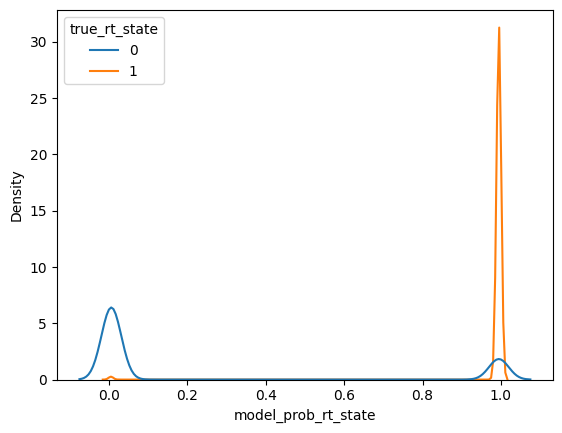

In [52]:
sns.kdeplot(data=cn_s_out, x='model_prob_rt_state', hue='true_rt_state')
plt.show()

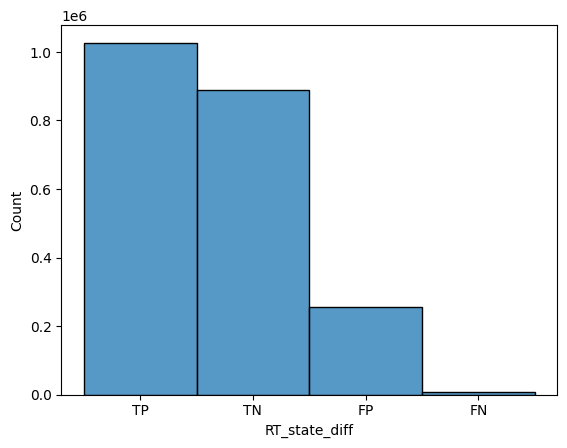

In [53]:
# add column that denotes true vs inferred RT state
cn_s_out['RT_state_diff'] = 'TN'
cn_s_out.loc[(cn_s_out['true_rt_state']==1) & (cn_s_out['model_maxprob_rt_state']==1), 'RT_state_diff'] = 'TP'
cn_s_out.loc[(cn_s_out['true_rt_state']==1) & (cn_s_out['model_maxprob_rt_state']==0), 'RT_state_diff'] = 'FN'
cn_s_out.loc[(cn_s_out['true_rt_state']==0) & (cn_s_out['model_maxprob_rt_state']==1), 'RT_state_diff'] = 'FP'
sns.histplot(data=cn_s_out, x='RT_state_diff')
plt.show()

### Look at per-cell accuracy statistics

In [54]:
u_to_cell_df = pd.DataFrame({'model_u': u_fit_s, 'cell_id': cn_s_reads_df.index})
u_to_cell_df.head()

model_u     cell_id
0  52.225876    cell_S_0
1  40.097298    cell_S_1
2  45.418312   cell_S_10
3  42.042965  cell_S_100
4  56.344124  cell_S_101

In [55]:
cn_s_out = pd.merge(cn_s_out, u_to_cell_df)
print(cn_s_out.shape)
cn_s_out.head()

(2180400, 26)


chr    start      end        gc     mcf7rt  bin_size clone_id  \
0   1  1000000  1500000  0.598330  81.441980    500000        A   
1   1  1500000  2000000  0.539496  79.131013    500000        A   
2   1  2000000  2500000  0.594508  78.557313    500000        A   
3   1  3000000  3500000  0.584570  70.388076    500000        A   
4   1  4000000  4500000  0.482572  48.663092    500000        A   

   clone_cn_state   cell_id  true_G1_state  ...  gc_slope  gc_int  sigma1  \
0             2.0  cell_S_0            2.0  ...       1.2     0.0    -1.0   
1             2.0  cell_S_0            2.0  ...       1.2     0.0    -1.0   
2             2.0  cell_S_0            2.0  ...       1.2     0.0    -1.0   
3             2.0  cell_S_0            2.0  ...       1.2     0.0    -1.0   
4             2.0  cell_S_0            2.0  ...       1.2     0.0    -1.0   

     A    B    rpm  model_prob_rt_state  model_maxprob_rt_state  \
0  0.1  0.0  287.0             0.995722                       1   
1  0.1  0.0  277.0             0.993115                       1   
2  0.1  0.0  284.0             0.993185                       1   
3  0.1  0.0  265.0             0.992603                       1   
4  0.1  0.0  128.0             0.003946                       0   

   RT_state_diff    model_u  
0             TP  52.225876  
1             TP  52.225876  
2             TP  52.225876  
3             TP  52.225876  
4             TN  52.225876  

[5 rows x 26 columns]

In [56]:
cell_summaries = []
for cell_id, chunk in cn_s_out.groupby('cell_id'):
    accuracy = 1.0 - (sum(abs(chunk['true_rt_state'] - chunk['model_maxprob_rt_state'])) / chunk.shape[0])
    true_s_time = chunk['true_s_time'].values[0] / 100.
    model_u = chunk['model_u'].values[0]
    temp = pd.DataFrame({'cell_id': [cell_id], 'rt_state_accuracy': [accuracy], 'true_s_time': [true_s_time],
                         'model_u': [model_u]})
    cell_summaries.append(temp)
    
cell_summaries = pd.concat(cell_summaries, ignore_index=True)
cell_summaries.head()

cell_id  rt_state_accuracy  true_s_time    model_u
0    cell_S_0           1.000000     0.461900  52.225876
1    cell_S_1           0.217024     0.720628  40.097298
2   cell_S_10           1.000000     0.289279  45.418312
3  cell_S_100           1.000000     0.170165  42.042965
4  cell_S_101           1.000000     0.545935  56.344124

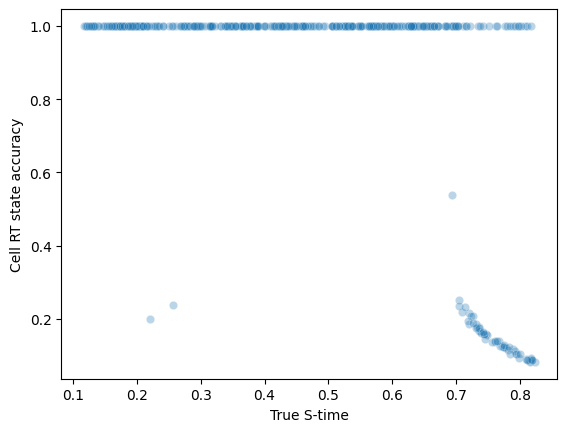

In [57]:
sns.scatterplot(data=cell_summaries, x='true_s_time', y='rt_state_accuracy', alpha=0.3)
plt.xlabel('True S-time')
plt.ylabel('Cell RT state accuracy')
plt.show()

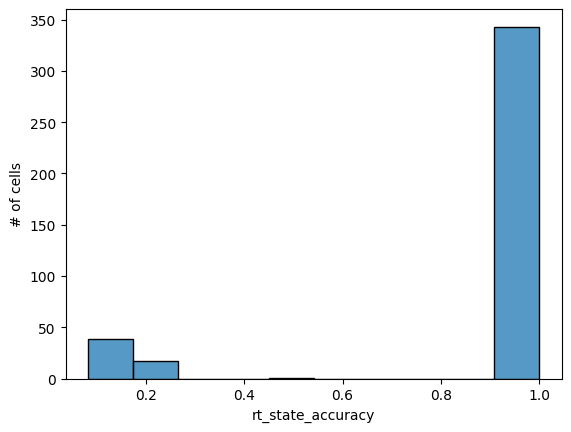

In [58]:
sns.histplot(data=cell_summaries, x='rt_state_accuracy')
plt.ylabel('# of cells')
plt.show()

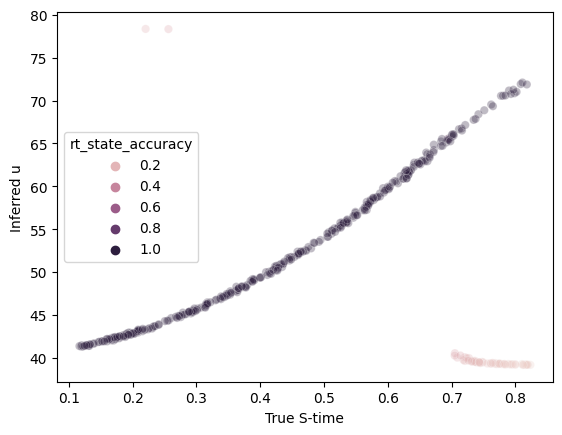

In [59]:
sns.scatterplot(data=cell_summaries, x='true_s_time', y='model_u', hue='rt_state_accuracy', alpha=0.3)
plt.xlabel('True S-time')
plt.ylabel('Inferred u')
plt.show()

### See what model accuracy is like for set of cells where the correct `u` was inferred

In [60]:
u_too_high = cell_summaries.query("true_s_time < 0.4 & model_u > 75")
u_too_high.head()

cell_id  rt_state_accuracy  true_s_time    model_u
241  cell_S_315           0.199046     0.220418  78.346382
308  cell_S_376           0.237021     0.256184  78.326210

In [61]:
u_too_low = cell_summaries.query("true_s_time > 0.6 & model_u < 45")
u_too_low.head()

cell_id  rt_state_accuracy  true_s_time    model_u
1     cell_S_1           0.217024     0.720628  40.097298
14  cell_S_110           0.219593     0.708980  40.051590
20  cell_S_116           0.125298     0.771717  39.306046
24   cell_S_12           0.138874     0.768137  39.414585
25  cell_S_120           0.105302     0.795560  39.268440

In [62]:
cell_summaries_correct_u = cell_summaries[~cell_summaries.cell_id.isin(u_too_high.cell_id)]
cell_summaries_correct_u = cell_summaries_correct_u[~cell_summaries_correct_u.cell_id.isin(u_too_low.cell_id)]
cell_summaries_correct_u.shape

(344, 4)

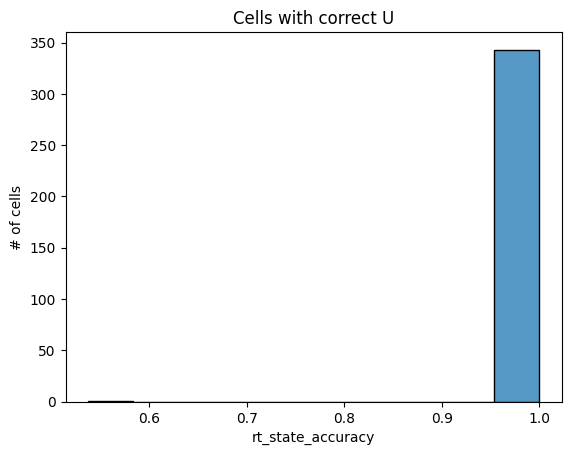

In [63]:
sns.histplot(data=cell_summaries_correct_u, x='rt_state_accuracy')
plt.ylabel('# of cells')
plt.title('Cells with correct U')
plt.show()

In [64]:
cell_summaries_correct_u.head()

cell_id  rt_state_accuracy  true_s_time    model_u
0    cell_S_0                1.0     0.461900  52.225876
2   cell_S_10                1.0     0.289279  45.418312
3  cell_S_100                1.0     0.170165  42.042965
4  cell_S_101                1.0     0.545935  56.344124
5  cell_S_102                1.0     0.329883  46.724697

In [65]:
# compute the accuracy of all cells with correct u
correct_u_accuracy = np.mean(cell_summaries_correct_u.rt_state_accuracy.values)
correct_u_accuracy

0.9986438374866142

### Look into what's going on for the one cell that has low accuracy despite the correct `u`

In [66]:
mysterious_bad_cell = cell_summaries_correct_u.query('rt_state_accuracy < 0.9')
mysterious_bad_cell

cell_id  rt_state_accuracy  true_s_time    model_u
21  cell_S_117           0.537149     0.694148  65.552589

In [67]:
mysterious_bad_cell_cn = cn_s_out.loc[cn_s_out['cell_id']==mysterious_bad_cell['cell_id'].values[0]]
mysterious_bad_cell_cn

chr      start        end        gc     mcf7rt  bin_size clone_id  \
114471   1    1000000    1500000  0.598330  81.441980    500000        A   
114472   1    1500000    2000000  0.539496  79.131013    500000        A   
114473   1    2000000    2500000  0.594508  78.557313    500000        A   
114474   1    3000000    3500000  0.584570  70.388076    500000        A   
114475   1    4000000    4500000  0.482572  48.663092    500000        A   
...     ..        ...        ...       ...        ...       ...      ...   
119917   X  152500000  153000000  0.530530  66.362452    500000        A   
119918   X  153000000  153500000  0.526266  74.503388    500000        A   
119919   X  153500000  154000000  0.513464  75.837731    500000        A   
119920   X  154000000  154500000  0.396106  61.508320    500000        A   
119921   X  154500000  155000000  0.384042  50.075926    500000        A   

        clone_cn_state     cell_id  true_G1_state  ...  gc_slope  gc_int  \
114471             2.0  cell_S_117            2.0  ...       1.2     0.0   
114472             2.0  cell_S_117            2.0  ...       1.2     0.0   
114473             2.0  cell_S_117            2.0  ...       1.2     0.0   
114474             2.0  cell_S_117            2.0  ...       1.2     0.0   
114475             2.0  cell_S_117            2.0  ...       1.2     0.0   
...                ...         ...            ...  ...       ...     ...   
119917             2.0  cell_S_117            2.0  ...       1.2     0.0   
119918             2.0  cell_S_117            2.0  ...       1.2     0.0   
119919             2.0  cell_S_117            2.0  ...       1.2     0.0   
119920             2.0  cell_S_117            2.0  ...       1.2     0.0   
119921             2.0  cell_S_117            2.0  ...       1.2     0.0   

        sigma1    A    B    rpm  model_prob_rt_state  model_maxprob_rt_state  \
114471    -1.0  0.1  0.0  360.0             0.993223                       1   
114472    -1.0  0.1  0.0  171.0             0.556810                       1   
114473    -1.0  0.1  0.0  168.0             0.620275                       1   
114474    -1.0  0.1  0.0  176.0             0.539082                       1   
114475    -1.0  0.1  0.0  334.0             0.992820                       1   
...        ...  ...  ...    ...                  ...                     ...   
119917    -1.0  0.1  0.0  317.0             0.993113                       1   
119918    -1.0  0.1  0.0  329.0             0.996470                       1   
119919    -1.0  0.1  0.0  170.0             0.521588                       1   
119920    -1.0  0.1  0.0  291.0             0.993276                       1   
119921    -1.0  0.1  0.0  151.0             0.473882                       0   

        RT_state_diff    model_u  
114471             TP  65.552589  
114472             FP  65.552589  
114473             FP  65.552589  
114474             FP  65.552589  
114475             TP  65.552589  
...               ...        ...  
119917             TP  65.552589  
119918             TP  65.552589  
119919             FP  65.552589  
119920             TP  65.552589  
119921             TN  65.552589  

[5451 rows x 26 columns]

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


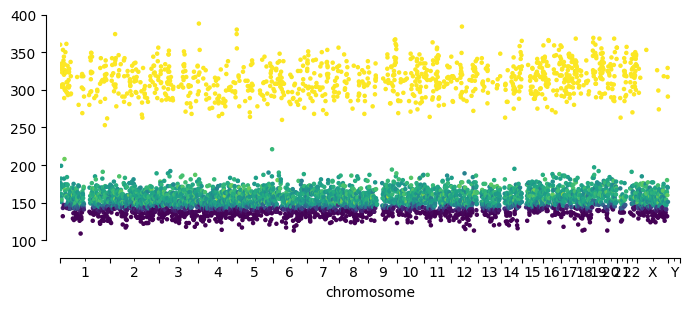

In [68]:
from scgenome.cnplot import plot_cell_cn_profile

fig, ax = plt.subplots(1, 1, figsize=(8, 3))
mysterious_bad_cell_cn['chr'] = mysterious_bad_cell_cn.chr.astype('category')
plot_cell_cn_profile(ax, mysterious_bad_cell_cn, 'reads', cn_field_name='model_prob_rt_state', rawy=True, cmap='viridis')
plt.show()

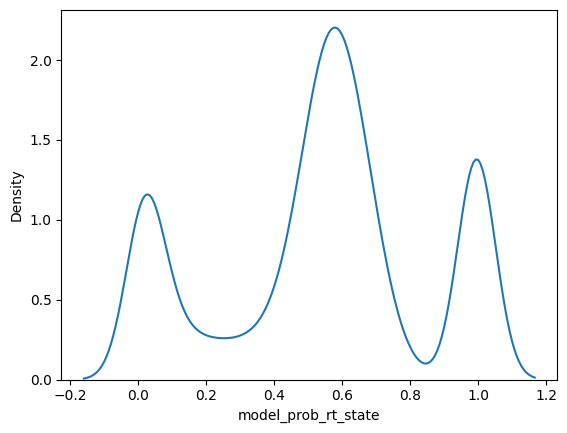

In [69]:
sns.kdeplot(data=mysterious_bad_cell_cn, x='model_prob_rt_state')
plt.show()

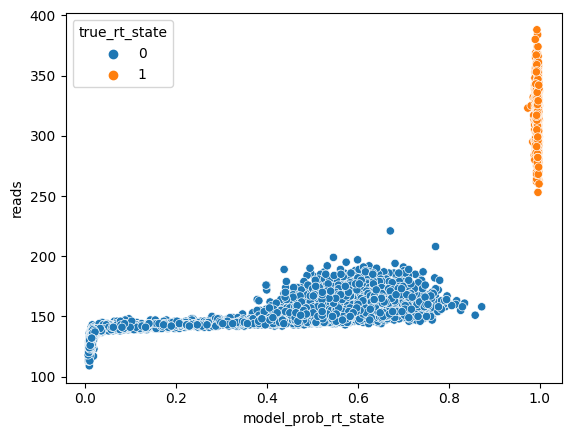

In [70]:
sns.scatterplot(data=mysterious_bad_cell_cn, x='model_prob_rt_state', y='reads', hue='true_rt_state')
plt.show()